# Bayesian Networks: The Sprinkler Model


In this tutorial, we'll explore how to build and perform inference in Bayesian networks using RxInfer. Bayesian networks are probabilistic graphical models that represent conditional dependencies between random variables through directed acyclic graphs. We'll use the `DiscreteTransition` node type to encode conditional probability tables (CPTs) that define how each variable depends on its parents in the network. Through a classic sprinkler example, we'll demonstrate how to construct these networks and perform probabilistic inference to answer queries about the model.


In [35]:
using RxInfer, Plots, GraphViz

This example implements a classic Bayesian network known as the sprinkler model. The model represents causal relationships between:

- Whether it is cloudy (clouded)
- Whether it is raining (rain) 
- Whether the sprinkler is on (sprinkler)
- Whether the grass is wet (wet_grass)
 
The relationships are:
- Cloudy weather influences both rain and sprinkler usage
- Both rain and sprinkler usage affect whether the grass is wet
 
We'll use this model to demonstrate inference under different scenarios and evidence.

The bayesian network for the sprinkler model is shown below:

![Sprinkler model diagram showing the relationships between clouded, rain, sprinkler and wet_grass nodes](sprinklermodel.jpg)



Let's translate this into an RxInfer model. We'll start by putting a `Categorial` prior on the clouded variable, and we'll use `DiscreteTransition` nodes to encode the CPTs for the rain and sprinkler variables, which depend on the clouded variable:

In [34]:
@model function sprinkler_model(wet_grass)
    clouded ~ Categorical([0.5, 0.5]) # Probability of cloudy being false or true
    rain ~ DiscreteTransition(clouded, [0.8 0.2; 0.2 0.8])
    sprinkler ~ DiscreteTransition(clouded, [0.5 0.9; 0.5 0.1])
    wet_grass ~ DiscreteTransition(sprinkler, [1.0 0.1; 0.0 0.9;;; 0.1 0.01; 0.9 0.99], rain)
end

Optionally, let's inspect the model structure that RxInfer creates using the GraphViz package:


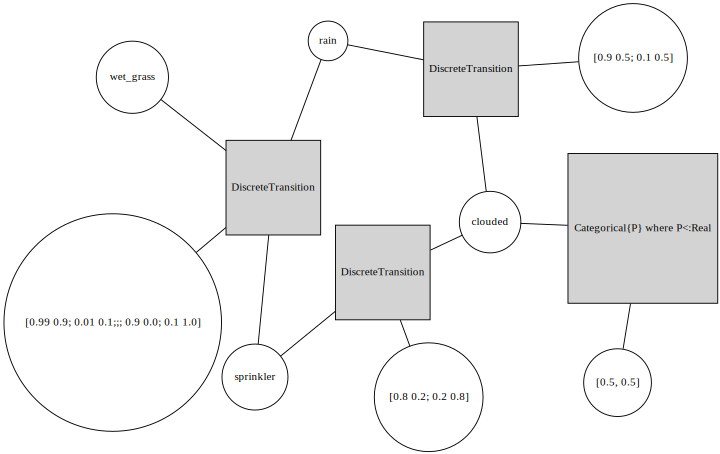

In [36]:
model_generator = sprinkler_model() | (wet_grass = [ 1.0, 0.0 ], )
model_to_plot   = RxInfer.getmodel(RxInfer.create_model(model_generator))
GraphViz.load(model_to_plot, strategy = :simple)

Because we have a loop in the resulting factor graph, we have to initialize messages to run the loopy belief propagation algorithm. We'll initialize the messages for the `sprinkler` variable to be uniform. Afterwards, we can run the inference with the `infer` function from `RxInfer`. Furthermore, we can specify the number of iterations to run the loopy belief propagation algorithm, and we can query the `free_energy` to monitor the convergence of the algorithm.

In [50]:
initialization = @initialization begin
    μ(sprinkler) = Categorical([0.5, 0.5])
end

result = infer(model=sprinkler_model(), data=(wet_grass=[0.0, 1.0],), iterations=10, initialization=initialization, free_energy=true)

Inference results:
  Posteriors       | available for (rain, sprinkler, clouded)
  Free Energy:     | Real[1.37793, 1.37793, 1.37793, 1.37793, 1.37793, 1.37793, 1.37793, 1.37793, 1.37793, 1.37793]


Let's plot the free energy to monitor the convergence of the loopy belief propagation algorithm:

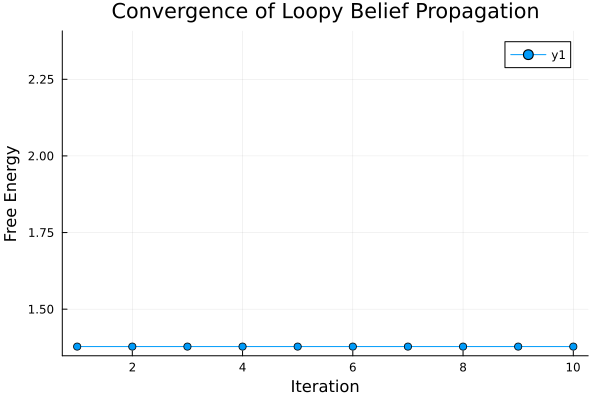

In [51]:
plot(result.free_energy, 
     xlabel="Iteration", 
     ylabel="Free Energy",
     title="Convergence of Loopy Belief Propagation",
     marker=:circle)

Great! It looks like the free energy is converging nicely. Now, let's inspect the posterior probabilities for the clouded variable:

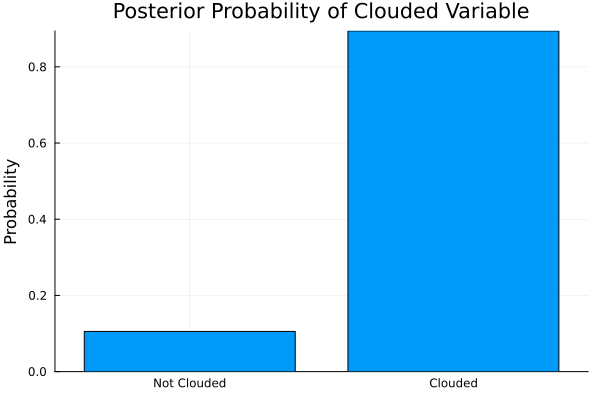

In [52]:
bar(last(result.posteriors[:clouded]).p,
    xticks=(1:2, ["Not Clouded", "Clouded"]),
    ylabel="Probability",
    title="Posterior Probability of Clouded Variable",
    legend=false)


In [16]:
@model function sprinkler_model(wet_grass, sprinkler_data, rain_data)
    clouded ~ Categorical([0.5, 0.5])
    rain ~ DiscreteTransition(clouded, [0.9 0.5; 0.1 0.5])
    rain_data ~ DiscreteTransition(rain, diageye(2))
    sprinkler ~ DiscreteTransition(clouded, [0.8 0.2; 0.2 0.8])
    sprinkler_data ~ DiscreteTransition(sprinkler, diageye(2))
    wet_grass ~ DiscreteTransition(sprinkler, [0.99 0.9; 0.01 0.1;;; 0.9 0.0; 0.1 1.0], rain)
end



In [33]:
result = infer(model=sprinkler_model(), data=(wet_grass=[1.0, 0.0], sprinkler_data=[0.0, 1.0], rain_data=missing), iterations=10, initialization=initialization)

Inference results:
  Posteriors       | available for (rain, sprinkler, clouded)
  Predictions      | available for (rain_data)


In [31]:
result.predictions[:rain_data]

10-element Vector{Categorical{Float64, Vector{Float64}}}:
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.9999985748993606, 1.4251006393675505e-6])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.9999999999990001, 1.0000000001299481e-12])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.9999999999990001, 1.0000000001400583e-12])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.9999999999990001, 1.0000000001400583e-12])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.9999999999990001, 1.0000000001400583e-12])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.9999999999990001, 1.0000000001400583e-12])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.9999999999990001, 1.0000000001400583e-12])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.9999999999990001, 1.0000000001400583e-12])
 Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p